# Motor Remaining Useful Life (RUL) Prediction: Baseline Pipeline

This notebook demonstrates a baseline approach for predicting the Remaining Useful Life (RUL) of motors using a dataset similar to NASA C-MAPSS. The workflow includes data loading, feature engineering, model training (XGBoost), and evaluation. 

---

**Outline:**
1. Import libraries and load data
2. Initial data analysis and visualization
3. Add RUL target variable
4. Aggregate features with rolling window
5. Feature engineering: derivatives, rolling stats, PCA
6. Train/test split
7. Baseline XGBoost model
8. Model evaluation and error analysis
9. (Optional) Data preparation for LSTM/GRU (sliding window)


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import catboost
import xgboost as xgb
# Load the dataset
df = pd.read_csv('../data/Data.csv')

# Display the first few rows
df.head()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,...,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,...,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002


## 1. Initial Data Analysis and Visualization

- Check data structure, types, and missing values
- Visualize cycle and sensor distributions


In [2]:
df.columns

Index(['id', 'cycle', 'p00', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07',
       'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17',
       'p18', 'p19', 'p20', 's1', 's2'],
      dtype='object')

In [3]:
# Show dataframe info and check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      16138 non-null  int64  
 1   cycle   16138 non-null  int64  
 2   p00     16138 non-null  float64
 3   p01     16138 non-null  float64
 4   p02     16138 non-null  float64
 5   p03     16138 non-null  float64
 6   p04     16138 non-null  float64
 7   p05     16138 non-null  float64
 8   p06     16138 non-null  float64
 9   p07     16138 non-null  float64
 10  p08     16138 non-null  int64  
 11  p09     16138 non-null  int64  
 12  p10     16138 non-null  int64  
 13  p11     16138 non-null  float64
 14  p12     16138 non-null  float64
 15  p13     16138 non-null  float64
 16  p14     16138 non-null  float64
 17  p15     16138 non-null  float64
 18  p16     16138 non-null  float64
 19  p17     16138 non-null  float64
 20  p18     16138 non-null  float64
 21  p19     16138 non-null  float64
 22

In [4]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
id       0
cycle    0
p00      0
p01      0
p02      0
p03      0
p04      0
p05      0
p06      0
p07      0
p08      0
p09      0
p10      0
p11      0
p12      0
p13      0
p14      0
p15      0
p16      0
p17      0
p18      0
p19      0
p20      0
s1       0
s2       0
dtype: int64


In [5]:
# Show basic statistics. Sensors p01 and p00, p07, p09, p10, p16 and p17 are not changed
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,16138.0,4.070789e+01,2.339535e+01,1.0000,20.0000,42.0000,61.0000,80.0000
cycle,16138.0,1.055481e+02,6.591530e+01,1.0000,51.0000,101.0000,153.0000,362.0000
p00,16138.0,5.186700e+02,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
p01,16138.0,1.300000e+00,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000
p02,16138.0,4.754426e+01,2.674218e-01,46.8600,47.3500,47.5200,47.7100,48.5300
p03,16138.0,5.214054e+02,7.382523e-01,518.6900,520.9400,521.4600,521.9400,523.3800
p04,16138.0,2.388097e+03,7.260372e-02,2387.8800,2388.0400,2388.0900,2388.1400,2388.5600
p05,16138.0,8.143933e+03,1.973135e+01,8099.9400,8132.8300,8140.7500,8148.8175,8293.7200
p06,16138.0,8.442581e+00,3.751962e-02,8.3249,8.4153,8.4398,8.4660,8.5848
p07,16138.0,3.000000e-02,1.387822e-17,0.0300,0.0300,0.0300,0.0300,0.0300


In [6]:
df = df.drop(columns=['p01', 'p00', 'p07', 'p09', 'p10', 'p16', 'p17'])

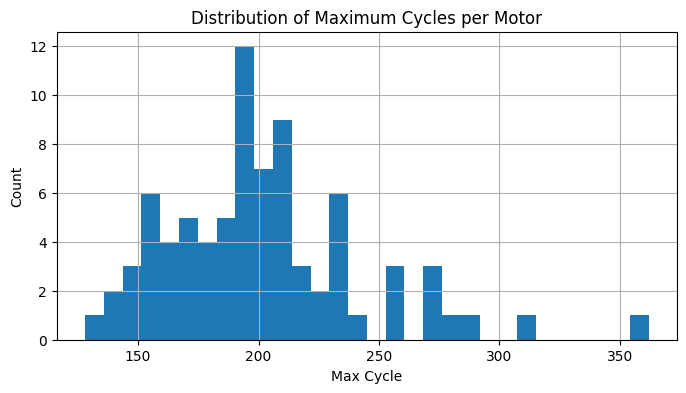

In [7]:
# Plot distribution of cycles per motor
plt.figure(figsize=(8,4))
df.groupby('id')['cycle'].max().hist(bins=30)
plt.title('Distribution of Maximum Cycles per Motor')
plt.xlabel('Max Cycle')
plt.ylabel('Count')
plt.show()

## 2. Add RUL (Remaining Useful Life) Target Variable

- For each motor, calculate RUL as the difference between the maximum cycle and the current cycle.


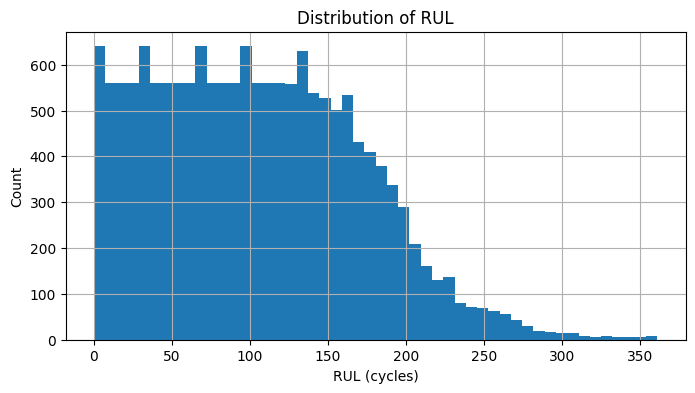

,id,cycle,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p18,p19,p20,s1,s2,rul
0,1,1,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,554.36,2388.06,9046.19,-0.0007,-0.0004,191
1,1,2,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,553.75,2388.04,9044.07,0.0019,-0.0003,190
2,1,3,47.27,522.42,2388.03,8133.23,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,554.26,2388.08,9052.94,-0.0043,0.0003,189
3,1,4,47.13,522.86,2388.08,8133.83,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,554.45,2388.11,9049.48,0.0007,0.0000,188
4,1,5,47.28,522.19,2388.04,8133.80,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,554.00,2388.06,9055.15,-0.0019,-0.0002,187


In [9]:
# Calculate RUL for each row 
df['max_cycle'] = df.groupby('id')['cycle'].transform('max')
df['rul'] = df['max_cycle'] - df['cycle']
df.drop('max_cycle', axis=1, inplace=True)

# Plot RUL distribution
plt.figure(figsize=(8,4))
df['rul'].hist(bins=50)
plt.title('Distribution of RUL')
plt.xlabel('RUL (cycles)')
plt.ylabel('Count')
plt.show()

df.head()

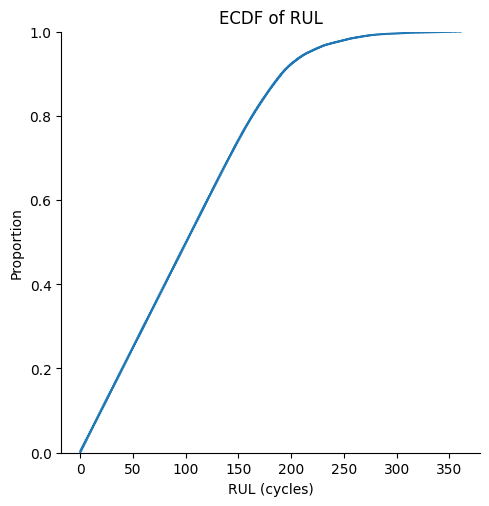

In [10]:
# ECDF plot for RUL (Remaining Useful Life)
#This plot shows the ECDF (Empirical Cumulative Distribution Function) of RUL. 
# It helps us see the distribution of remaining useful life for all engines.
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data=df, x='rul', kind='ecdf')
plt.title('ECDF of RUL')
plt.xlabel('RUL (cycles)')
plt.ylabel('Proportion')
plt.show()

In [11]:
# Check correlation with RUL. There are p03, p04, p05, p06, p07, p08, p09, p10, and p11 that are highly correlated with RUL.
df.corr()['rul'].sort_values(ascending=False)

rul      1.000000
p03      0.678935
p18      0.662448
p13      0.646511
p12      0.637581
id       0.028491
s1      -0.000150
s2      -0.002669
p05     -0.310472
p20     -0.391014
p19     -0.566356
p04     -0.566580
p14     -0.590030
p08     -0.613475
p11     -0.616728
p06     -0.648625
p15     -0.686511
p02     -0.704527
cycle   -0.769964
Name: rul, dtype: float64

In [12]:
# Column like as the cycle is time series data, so we need to create rolling features

# Note: When you create rolling window features, the first (window_size-1) rows for each engine will have NaN values.
# This is normal because there is not enough history for the window.
# To use PCA or any model that does not support NaN, you should fill these NaN values.
# The most common way is to fill NaN with the mean or median of the column.

sensor_cols = [col for col in df.columns if col.startswith('p') or col.startswith('s')]
sensor_cols

['p02',
 'p03',
 'p04',
 'p05',
 'p06',
 'p08',
 'p11',
 'p12',
 'p13',
 'p14',
 'p15',
 'p18',
 'p19',
 'p20',
 's1',
 's2']

## 3. Aggregate Features with Rolling Window

- For each motor and each cycle, compute rolling window aggregates (mean, std, min, max) for sensor features over the last N cycles (e.g., N=30).
- This helps capture recent trends and variability for each engine.


In [13]:
# Column like as the cycle is time series data, so we need to create rolling features

# Note: When you create rolling window features, the first (window_size-1) rows for each engine will have NaN values.
# This is normal because there is not enough history for the window.
# To use PCA or any model that does not support NaN, you should fill these NaN values.
# The most common way is to fill NaN with the mean or median of the column.

window_size = 45


# Compute rolling window aggregates for each sensor feature
def add_rolling_features(df, cols, window):
    for func in ['mean', 'std', 'min', 'max']:
        for col in cols:
            df[f'{col}_roll{window}_{func}'] = (
                df.groupby('id')[col]
                  .transform(lambda x: x.rolling(window, min_periods=1).agg(func))
            )
    return df

df = add_rolling_features(df, sensor_cols, window_size)

df[[c for c in df.columns if 'roll' in c]].head()

,p02_roll45_mean,p03_roll45_mean,p04_roll45_mean,p05_roll45_mean,p06_roll45_mean,p08_roll45_mean,p11_roll45_mean,p12_roll45_mean,p13_roll45_mean,p14_roll45_mean,...,p11_roll45_max,p12_roll45_max,p13_roll45_max,p14_roll45_max,p15_roll45_max,p18_roll45_max,p19_roll45_max,p20_roll45_max,s1_roll45_max,s2_roll45_max
0,47.470,521.660,2388.020,8138.620000,8.419500,392.000000,641.820000,39.060000,23.419000,1589.700000,...,641.82,39.06,23.4190,1589.70,1400.60,554.36,2388.06,9046.19,-0.0007,-0.0004
1,47.480,521.970,2388.045,8135.055000,8.425650,392.000000,641.985000,39.030000,23.421300,1590.760000,...,642.15,39.06,23.4236,1591.82,1403.14,554.36,2388.06,9046.19,0.0019,-0.0003
2,47.410,522.120,2388.040,8134.446667,8.423033,391.333333,642.106667,39.003333,23.395600,1589.836667,...,642.35,39.06,23.4236,1591.82,1404.20,554.36,2388.08,9052.94,0.0019,0.0003
3,47.340,522.305,2388.050,8134.292500,8.409325,391.500000,642.167500,38.972500,23.390175,1588.075000,...,642.35,39.06,23.4236,1591.82,1404.20,554.45,2388.11,9052.94,0.0019,0.0003
4,47.328,522.282,2388.048,8134.194000,8.413340,391.800000,642.208000,38.958000,23.393020,1587.030000,...,642.37,39.06,23.4236,1591.82,1406.22,554.45,2388.11,9055.15,0.0019,0.0003


## 4. Feature Engineering: Derivatives, Rolling Statistics, PCA

- Add first-order differences (derivatives) for sensor features.
- Optionally, apply PCA to reduce dimensionality of rolling features.


In [14]:
from sklearn.impute import SimpleImputer

rolling_cols = [c for c in df.columns if 'roll' in c or 'diff1' in c]
imputer = SimpleImputer(strategy='mean')
df[rolling_cols] = imputer.fit_transform(df[rolling_cols])

## 5. Train/Test Split

- Split the data into training and test sets. We will use the last 20 cycles of each engine as the test set. The rest will be used for training.


count    12910.000000
mean       104.464679
std         65.776079
min          0.000000
25%         50.000000
50%        100.000000
75%        151.000000
max        361.000000
Name: rul, dtype: float64
count    3228.000000
mean      104.881970
std        66.478363
min         0.000000
25%        50.000000
50%       100.000000
75%       153.000000
max       359.000000
Name: rul, dtype: float64


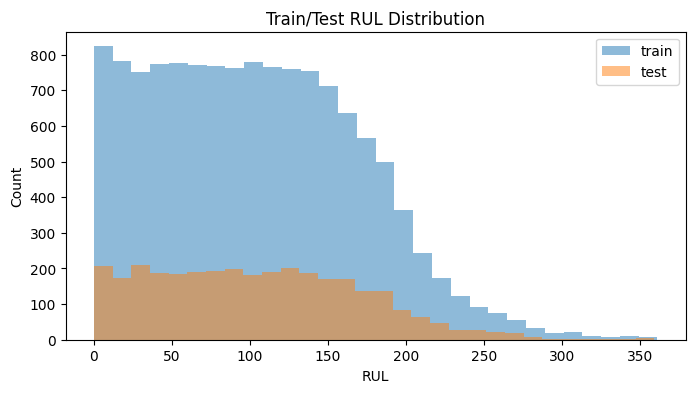

In [17]:
from sklearn.model_selection import train_test_split

# Create bins for RUL to stratify the split
# This helps to ensure that both training and test sets have a similar distribution of RUL values
# We use pd.qcut to create quantile-based bins, which helps in stratifying the split
# The 'duplicates' parameter is set to 'drop' to avoid issues with bins that have the same edges
# This is useful when the RUL values are not evenly distributed
df['rul_bin'] = pd.qcut(df['rul'], q=10, duplicates='drop')

# Стратифицированный сплит по бинам
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['rul_bin']
)

# Удаляем вспомогательный столбец
train_df = train_df.drop(columns='rul_bin')
test_df = test_df.drop(columns='rul_bin')

print(train_df['rul'].describe())
print(test_df['rul'].describe())
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(train_df['rul'], bins=30, alpha=0.5, label='train')
plt.hist(test_df['rul'], bins=30, alpha=0.5, label='test')
plt.xlabel('RUL')
plt.ylabel('Count')
plt.legend()
plt.title('Train/Test RUL Distribution')
plt.show()

## 6. Baseline XGBoost Model

- We will train a simple XGBoost model to predict RUL. We use only the rolling window features, derivatives, and PCA features.


In [18]:
# Select features for training
feature_cols = [c for c in train_df.columns if ('roll' in c or 'diff1' in c or 'pca_roll' in c) and not c.startswith('rul')]

X_train = train_df[feature_cols]
y_train = train_df['rul']
X_test = test_df[feature_cols]
y_test = test_df['rul']

# Train XGBoost regressor
model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Show first 5 predictions and true values
for i in range(5):
    print(f"Predicted RUL: {y_pred[i]:.1f}, True RUL: {y_test.iloc[i]}")

Predicted RUL: 121.2, True RUL: 130
Predicted RUL: 144.0, True RUL: 158
Predicted RUL: 177.8, True RUL: 141
Predicted RUL: 203.8, True RUL: 210
Predicted RUL: 43.8, True RUL: 46


## 7. Model Evaluation and Error Analysis

- We will check the quality of our model using MAE and RMSE. We will also plot the predicted and true RUL values.


MAE: 7.30
RMSE: 10.31


/tmp/ipykernel_40404/3506518785.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')


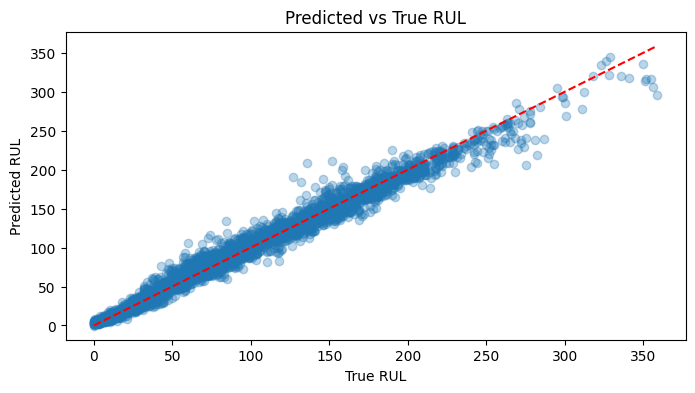

The model predicts RUL with some error. Most points are close to the red line, but some are far. The model can be improved with more features or tuning.


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot predicted vs true RUL
plt.figure(figsize=(8,4))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Predicted vs True RUL')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')
plt.show()

# Simple analysis in English (B1 level)
print("The model predicts RUL with some error. Most points are close to the red line, but some are far. The model can be improved with more features or tuning.")